In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import datetime
import math

In [2]:
# Import the observations data.
# Column names for observed mongoose counts follow this scheme:
#   S = susceptible
#   I = infected
#   T = total
#   M = male
#   F = female
#   U = unknown sex
#   A = adult
#   S = sub-adult
#   J = juvenile
#   P = pregnant,
#   L = lactating
#   EN = enlarged nipples
# For example, susceptible juvenile males would be in column 'SJM'.

obs_data = pd.read_csv('../Data/Observations.csv', parse_dates=['ObservationTime'])
obs_data = obs_data[obs_data.columns.drop(list(obs_data.filter(regex='Uncertain')))]

In [3]:
# Infer missing values where component values roll up to a sum.
# (e.g. total susceptible = susceptible adults + susceptible sub-adults + susceptible juveniles)

def infer_observations(df, total_column, component_columns):
    df[total_column] = df.apply(
        # total should be the sum of the components (ignoring NaN), but we ignore when the total is zero
        lambda row: (row[component_columns].sum() if row[component_columns].sum() > 0 else np.nan) if np.isnan(row[total_column]) else row[total_column],
        axis = 1
    )
    for col in component_columns:
        df[col] = df.apply(
            # components should be the tota minus the other components (if all other components are present)
            lambda row: row[total_column]-(row[[x for x in component_columns if x != col]].sum(skipna=False)) if np.isnan(row[col]) else row[col],
            axis = 1
        )

initial_counts = obs_data.count()

# susceptible/infected counts by sex should be the sum of susceptible/infected 
# counts by sex broken down by age group
infer_observations(obs_data, 'SM', ['SAM','SSM','SJM'])
infer_observations(obs_data, 'IM', ['IAM','ISM','IJM'])
infer_observations(obs_data, 'SF', ['SAF','SSF','SJF'])
infer_observations(obs_data, 'IF', ['IAF','ISF','IJF'])
infer_observations(obs_data, 'SU', ['SAU','SSU','SJU'])
infer_observations(obs_data, 'IU', ['IAU','ISU','IJU'])
# susceptible/infected totals should be the sum of susceptible/infected
# counts broken down by age group and broken down by sex
infer_observations(obs_data, 'ST', ['SA','SS','SJ'])
infer_observations(obs_data, 'IT', ['IA','IS','IJ'])
infer_observations(obs_data, 'ST', ['SM','SF','SU'])
infer_observations(obs_data, 'IT', ['IM','IF','IU'])

print('{} observation counts inferred.'.format((obs_data.count()-initial_counts).sum()))

1217 observation counts inferred.


In [4]:
# Add a column for total count
obs_data['T'] = (obs_data['ST'].fillna(0) + obs_data['IT'].fillna(0)).replace(0, np.nan)

# Add columns for total count by age group.
obs_data['A'] = (obs_data['SA'].fillna(0) + obs_data['IA'].fillna(0)).replace(0, np.nan)
obs_data['S'] = (obs_data['SS'].fillna(0) + obs_data['IS'].fillna(0)).replace(0, np.nan)
obs_data['J'] = (obs_data['SJ'].fillna(0) + obs_data['IJ'].fillna(0)).replace(0, np.nan)

In [5]:
# Compute basic statistics about the observed total counts per troop.
obs_data.groupby(obs_data['Troop']).agg({'T':{'count','mean','min','max'},
                                         'A':{'count','mean','min','max'},
                                         'S':{'count','mean','min','max'},
                                         'J':{'count','mean','min','max'}})

T                            A                           S  \
            mean count   max   min       mean count   max   min      mean   
Troop                                                                       
AIR     8.250000     4  12.0   4.0   6.333333     3   7.0   5.0  3.000000   
BDF    21.142857     7  30.0  15.0        NaN     0   NaN   NaN       NaN   
BOR    21.000000     1  21.0  21.0        NaN     0   NaN   NaN       NaN   
CCH    23.951923   104  51.0   2.0  12.731343    67  45.0   1.0  8.194444   
CGL    28.485549   173  69.0   1.0  20.731707    82  49.0   2.0  7.142857   
COR     7.000000     1   7.0   7.0        NaN     0   NaN   NaN       NaN   
CSL    14.226204   893  68.0   1.0  12.657718   149  31.0   1.0  9.750000   
CSP          NaN     0   NaN   NaN        NaN     0   NaN   NaN       NaN   
DUM    20.000000     4  30.0  10.0        NaN     0   NaN   NaN       NaN   
DWN     3.000000     2   4.0   2.0        NaN     0   NaN   NaN       NaN   
EVL    14.555556    27  31.0   2.0   8.866667    15  21.0   2.0  3.000000   
FER          NaN     0   NaN   NaN        NaN     0   NaN   NaN       NaN   
HAS          NaN     0   NaN   NaN        NaN     0   NaN   NaN       NaN   
HIP    18.044776    67  53.0   1.0  13.333333    42  28.0   1.0  5.565217   
IHA     9.000000     1   9.0   9.0        NaN     0   NaN   NaN       NaN   
IHE    16.000000     1  16.0  16.0        NaN     0   NaN   NaN       NaN   
IHW    13.500000     2  14.0  13.0        NaN     0   NaN   NaN       NaN   
KAB    13.500000     2  14.0  13.0   7.000000     2   8.0   6.0  2.000000   
KAL    10.000000     1  10.0  10.0  10.000000     1  10.0  10.0       NaN   
KAZ    21.333333    18  53.0   1.0  11.250000     4  19.0   1.0  9.000000   
KBV    11.500000     2  15.0   8.0        NaN     0   NaN   NaN       NaN   
KIN    41.000000     1  41.0  41.0  41.000000     1  41.0  41.0       NaN   
KUB    16.198864   176  38.0   1.0   9.627273   110  30.0   1.0  7.089744   
KYM    20.500000     2  23.0  18.0        NaN     0   NaN   NaN       NaN   
LES    12.666667     3  17.0   7.0  14.000000     1  14.0  14.0       NaN   
MAR    20.000000     1  20.0  20.0        NaN     0   NaN   NaN       NaN   
MOW     6.833333   138  14.0   1.0   3.308511    94   8.0   1.0  3.359375   
NAE    20.000000     1  20.0  20.0        NaN     0   NaN   NaN       NaN   
NAW    13.000000     2  17.0   9.0        NaN     0   NaN   NaN  6.000000   
NMW     6.800000     5  12.0   5.0   5.666667     3   7.0   5.0  5.000000   
OPG    10.428571     7  18.0   6.0  12.500000     2  14.0  11.0  3.000000   
SEF     6.476562   128  20.0   1.0   4.203704   108   8.0   1.0  2.181818   
SEJ    13.923077    26  21.0   7.0   8.611111    18  16.0   3.0  5.384615   
SER     8.000000     3  11.0   6.0   5.000000     1   5.0   5.0       NaN   
SEV    36.000000     2  47.0  25.0        NaN     0   NaN   NaN       NaN   
SIJ    11.375000     8  21.0   6.0        NaN     0   NaN   NaN       NaN   
SLE          NaN     0   NaN   NaN        NaN     0   NaN   NaN       NaN   
TRS     7.097345   113  16.0   1.0   4.869565    69  14.0   1.0  4.454545   
VSL     4.000000     1   4.0   4.0        NaN     0   NaN   NaN       NaN   
WCJ    14.133333    15  30.0   4.0  13.444444     9  18.0  11.0  6.800000   
WHS    11.000000     1  11.0  11.0        NaN     0   NaN   NaN       NaN   
ZEB    17.000000     1  17.0  17.0  11.000000     1  11.0  11.0  2.000000   

                                 J                   
      count   max   min       mean count   max  min  
Troop                                                
AIR       2   5.0   1.0   4.000000     1   4.0  4.0  
BDF       0   NaN   NaN        NaN     0   NaN  NaN  
BOR       0   NaN   NaN        NaN     0   NaN  NaN  
CCH      36  34.0   1.0   8.228571    35  23.0 -2.0  
CGL      63  25.0 -13.0   8.923077    39  24.0 -1.0  
COR       0   NaN   NaN        NaN     0   NaN  NaN  
CSL     108  27.0  -5.0   5.452381   126  17.0  1.0  
CSP      

In [6]:
obs_data['TimeSinceLast'] = obs_data.groupby('Troop')['ObservationTime'].transform(lambda x: x.dt.date.diff())
obs_data['TDiff'] = obs_data.groupby('Troop')['T'].transform(lambda x: x.where(x.isnull(), x.fillna(method='ffill').diff()))
obs_data[['TimeSinceLast','TDiff']].describe()

,TimeSinceLast,TDiff
count,20809,1906.000000
mean,0 days 22:09:20.872699,-0.030955
std,14 days 10:08:13.222673,11.316751
min,0 days 00:00:00,-59.000000
25%,0 days 00:00:00,-5.000000
50%,0 days 00:00:00,0.000000
75%,0 days 00:00:00,4.000000
max,971 days 00:00:00,56.000000


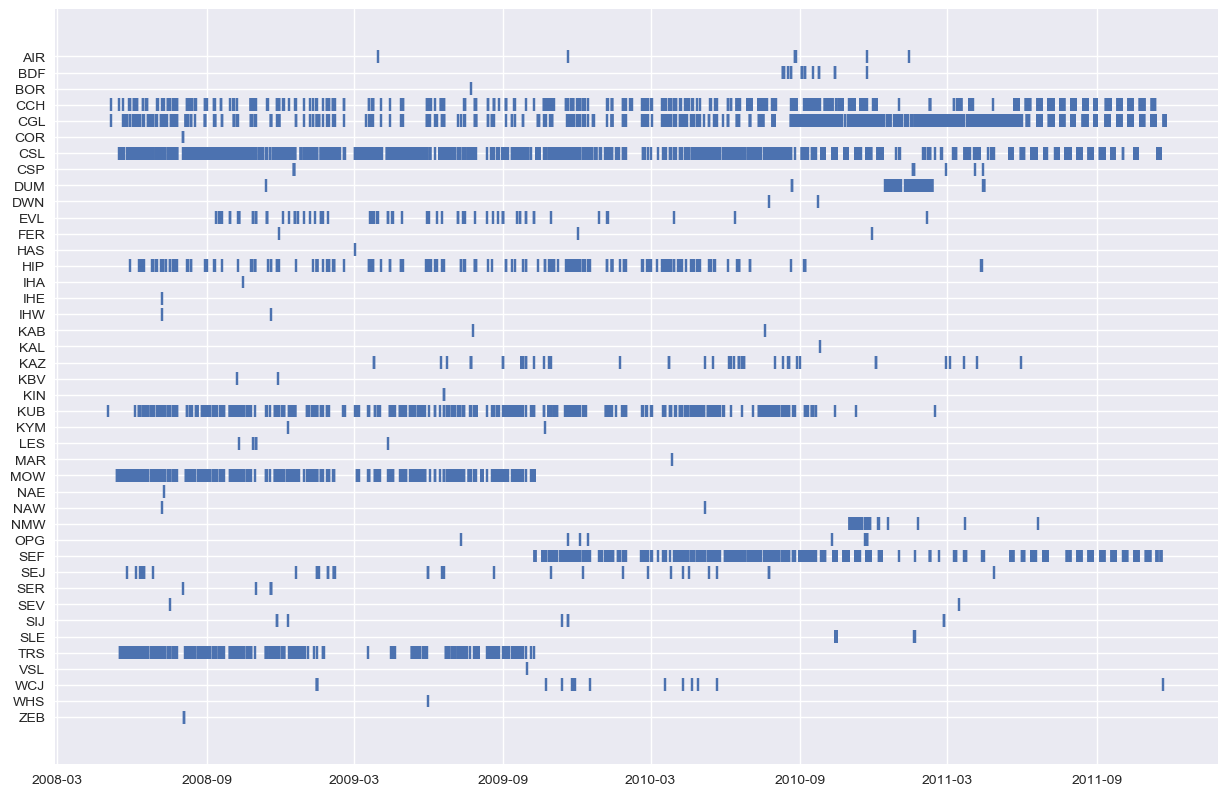

In [7]:
obs_dates = obs_data.groupby('Troop')['ObservationTime'].apply(list).sort_index(ascending=False)
fig, ax = plt.subplots(figsize=(15, 10), dpi=100)
plt.eventplot(obs_dates, linelengths=0.8)
plt.yticks(np.arange(len(obs_dates)), list(obs_dates.index))
plt.show()

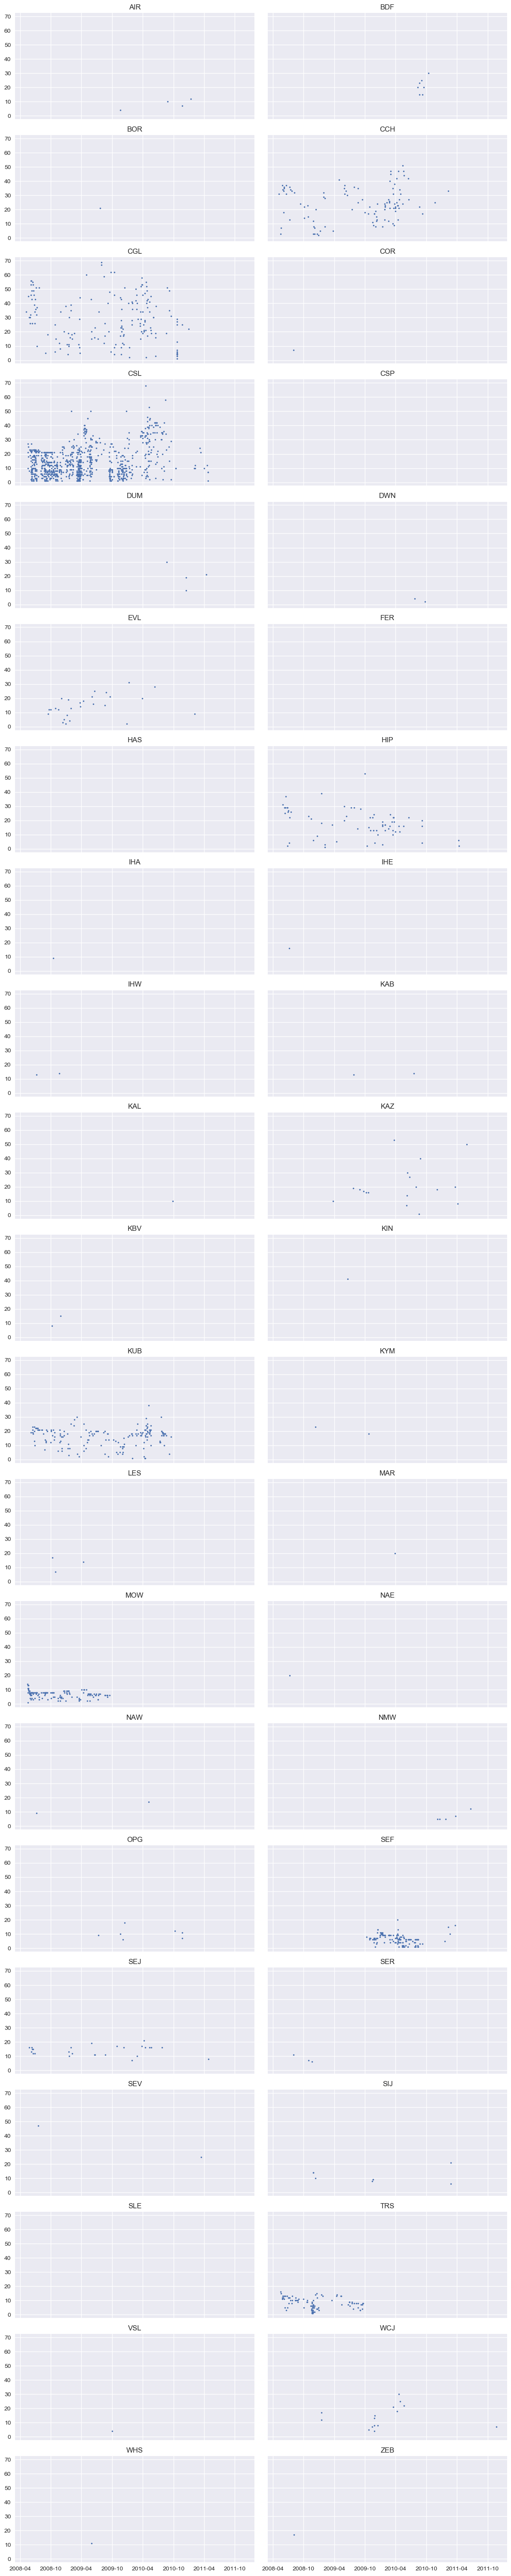

In [8]:
troops = sorted(obs_data['Troop'].unique())
fig,ax = plt.subplots(nrows=math.ceil(len(troops)/2), ncols=2, figsize=(12, 60), dpi=100, sharex='all', sharey='all', )
for idx, troop in enumerate(troops):
    troop_data = obs_data[obs_data['Troop']==troop]
    axes = ax[math.floor(idx/2), idx%2]
    axes.plot_date(x=troop_data['ObservationTime'], y=troop_data['T'], markersize=2.5)
    axes.set_title(troop)
plt.tight_layout()